In [72]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve, auc
import xgboost
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

In [4]:
data = pd.read_csv('amazon.csv')

In [5]:
data.tail()

,reviewText,Positive
19995,this app is fricken stupid.it froze on the kin...,0
19996,Please add me!!!!! I need neighbors! Ginger101...,1
19997,love it! this game. is awesome. wish it had m...,1
19998,I love love love this app on my side of fashio...,1
19999,This game is a rip off. Here is a list of thin...,0


binary label, 1 for positive, 0 for negative

In [6]:
data['reviewText'][19996] #Label 1, Postive News

'Please add me!!!!! I need neighbors! Ginger1016!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! thanks bunches! this is such an awesome game.. it is so much fun! it is a lot like farmville on FB...'

In [7]:
data['reviewText'][19995] #Label 0, Negative News

'this app is fricken stupid.it froze on the kindle and it wont allow me to place most iteams just ignore the 5 * people their wrong on so many levels. the people who made this game so were you excidently press the wrong button you them your own money. jer'

In [8]:
data.isnull().sum()

reviewText    0
Positive      0
dtype: int64

No Null Values

In [9]:
data['Positive'].unique()

array([1, 0], dtype=int64)

In [10]:
data.shape

(20000, 2)

In [11]:
data['Positive'].value_counts() #Imbalanced Dataset

Positive
1    15233
0     4767
Name: count, dtype: int64

# Create word clouds

In [12]:
import wordcloud
from wordcloud import WordCloud
def plot_wordcloud(reviewText,title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reviewText)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)

negative = ' '.join(data[data['Positive'] == 0]['reviewText'])
positive = ' '.join(data[data['Positive'] == 1]['reviewText'])

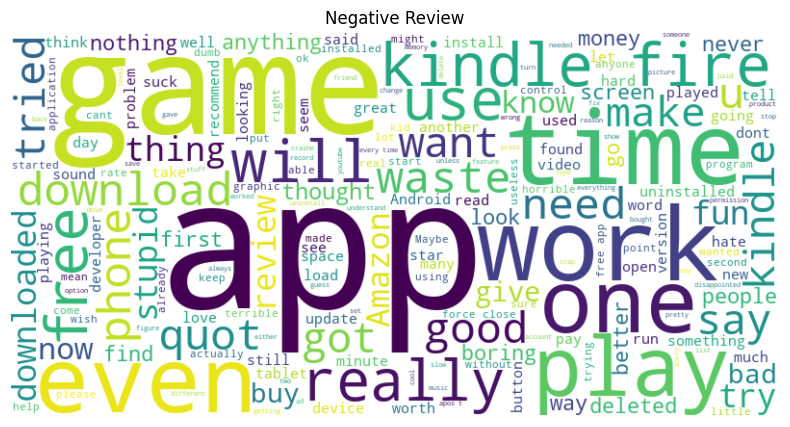

In [13]:
plot_wordcloud(negative, 'Negative Review')
plt.show()

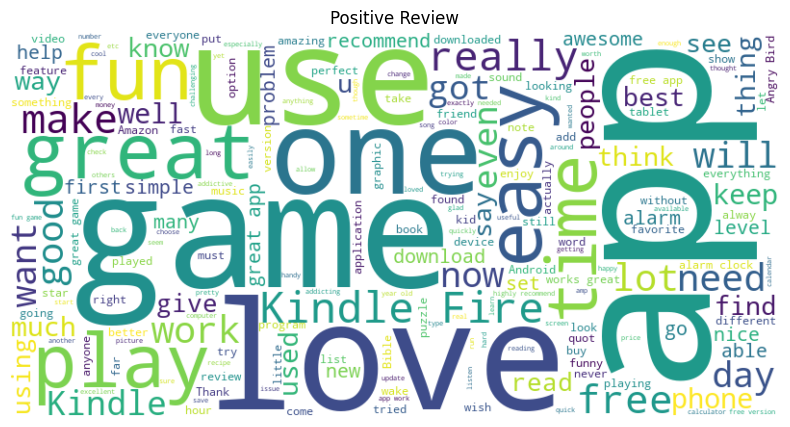

In [14]:
plot_wordcloud(positive, 'Positive Review')
plt.show()

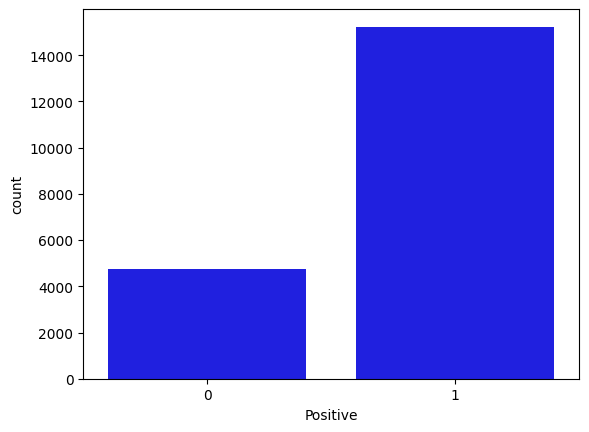

In [15]:
sns.countplot(x='Positive', data=data, color='blue')
plt.show()

In [16]:
one = (15233/(15233+4767)) * 100 #1    15233 0     4767
zero = (4767/(15233+4767)) * 100

print('Positive {} percent of total Reviews'.format(one)) 
print('Negative {} percent of total Reviews'.format(zero))

Positive 76.165 percent of total Reviews
Negative 23.835 percent of total Reviews


# Imbalanced Dataset

# data cleaning and preprocessing

In [17]:
text_column = 'reviewText'
label_column ='Positive'

In [18]:
english_stopwords = set(stopwords.words('english'))
english_punctuation = string.punctuation

In [19]:
def preprocess_text(text):
    # Remove punctuation
    remove_punc = [char for char in text if char not in english_punctuation]
    clean_text = ''.join(remove_punc) # char joining

    #Remove stopwords
    words = clean_text.split()
    text = ([word for word in words if word.lower() not in english_stopwords])
    return text

In [20]:
data[text_column] = data[text_column].apply(preprocess_text)

In [21]:
data[text_column]

0        [one, best, apps, acording, bunch, people, agr...
1        [pretty, good, version, game, free, LOTS, diff...
2        [really, cool, game, bunch, levels, find, gold...
3        [silly, game, frustrating, lots, fun, definite...
4        [terrific, game, pad, Hrs, fun, grandkids, lov...
                               ...                        
19995    [app, fricken, stupidit, froze, kindle, wont, ...
19996    [Please, add, need, neighbors, Ginger1016, tha...
19997    [love, game, awesome, wish, free, stuff, house...
19998    [love, love, love, app, side, fashion, story, ...
19999    [game, rip, list, things, MAKE, BETTERbull, Fi...
Name: reviewText, Length: 20000, dtype: object

In [22]:
data[text_column][0]

['one',
 'best',
 'apps',
 'acording',
 'bunch',
 'people',
 'agree',
 'bombs',
 'eggs',
 'pigs',
 'TNT',
 'king',
 'pigs',
 'realustic',
 'stuff']

# Lemmatization

In [23]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    lemmatized_text = ' '.join([lemmatizer.lemmatize(word) for word in text])
    return lemmatized_text

data[text_column] = data[text_column].apply(lemmatize_text)

In [24]:
data[text_column] 

0        one best apps acording bunch people agree bomb...
1        pretty good version game free LOTS different l...
2        really cool game bunch level find golden egg s...
3        silly game frustrating lot fun definitely reco...
4        terrific game pad Hrs fun grandkids love Great...
                               ...                        
19995    app fricken stupidit froze kindle wont allow p...
19996    Please add need neighbor Ginger1016 thanks bun...
19997    love game awesome wish free stuff house didnt ...
19998    love love love app side fashion story fight wo...
19999    game rip list thing MAKE BETTERbull First NEED...
Name: reviewText, Length: 20000, dtype: object

In [25]:
data[text_column][0]

'one best apps acording bunch people agree bomb egg pig TNT king pig realustic stuff'

# TF-IDF Vectorization

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(data[text_column])
y = data[label_column]

In [27]:
x

<20000x22617 sparse matrix of type '<class 'numpy.float64'>'
	with 310882 stored elements in Compressed Sparse Row format>

In [28]:
np.array(x)

array(<20000x22617 sparse matrix of type '<class 'numpy.float64'>'
	with 310882 stored elements in Compressed Sparse Row format>,
      dtype=object)

# Before Sampling

Since the dataset is imabalanced so tried sampling to see the performance before sampling and after sampling

# Split dataset into training and testing sets

In [29]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)

In [30]:
xtrain.shape

(14000, 22617)

In [31]:
xtest.shape

(6000, 22617)

# Evaluate models

In [32]:
def evaluate_model(model, xtest, ytest):
    y_pred = model.predict(xtest)
    accuracy = accuracy_score(ytest, y_pred)
    cm = confusion_matrix(ytest, y_pred)

    return {
        'Accuracy': accuracy,
        'Confusion Matrix': cm,
    }

# Logistic Regression
Logistic Regression is a simple yet powerful linear model that is often used as a baseline for text classification tasks

In [33]:
lr_model = LogisticRegression()
lr_model.fit(xtrain, ytrain)

LogisticRegression()

In [34]:
lr_results = evaluate_model(lr_model, xtest, ytest)
lr_results

{'Accuracy': 0.8846666666666667,
 'Confusion Matrix': array([[ 853,  558],
        [ 134, 4455]], dtype=int64)}

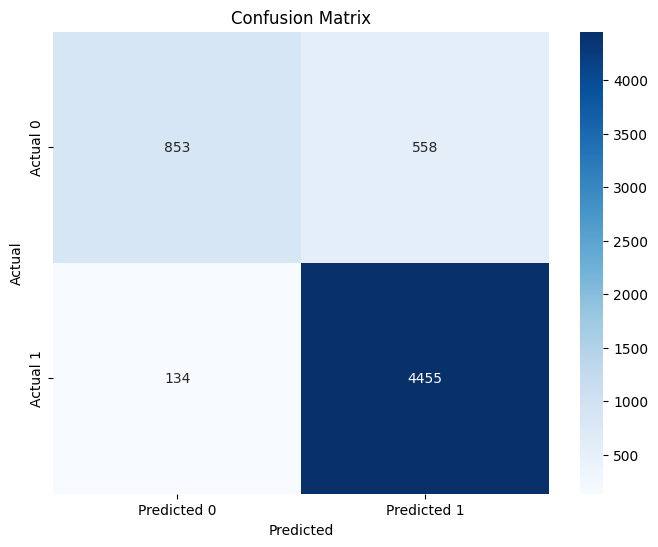

In [35]:
# Create a heatmap
cm = confusion_matrix(ytest, lr_model.predict(xtest))
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [36]:
print(classification_report(ytest, lr_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.86      0.60      0.71      1411
           1       0.89      0.97      0.93      4589

    accuracy                           0.88      6000
   macro avg       0.88      0.79      0.82      6000
weighted avg       0.88      0.88      0.88      6000



# ROC Curve
The higher the AUC, the better the model is at distinguishing between positive and negative classes

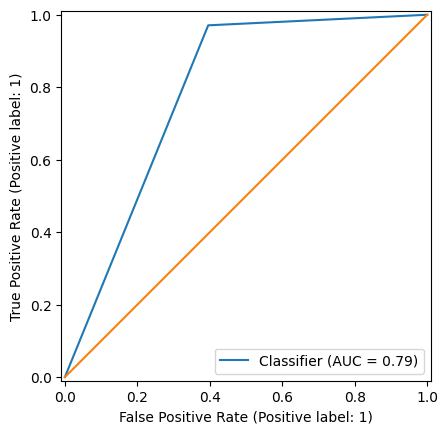

In [37]:
RocCurveDisplay.from_predictions(ytest, lr_model.predict(xtest))
plt.plot([0,1],[0,1])
plt.show()

# SVM Model
SVM, especially with a linear kernel, is highly effective for high-dimensional text data

In [38]:
svm_model = SVC(kernel='linear')
svm_model.fit(xtrain, ytrain)
svm_results = evaluate_model(svm_model, xtest, ytest)
svm_results

{'Accuracy': 0.8911666666666667,
 'Confusion Matrix': array([[ 981,  430],
        [ 223, 4366]], dtype=int64)}

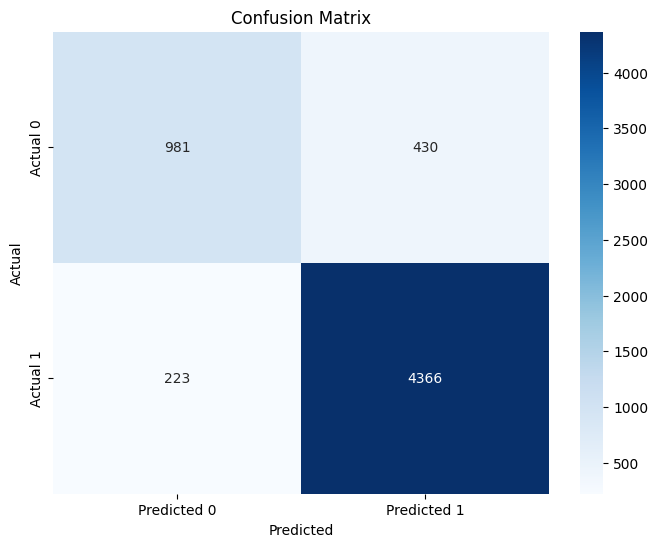

In [39]:
# Create a heatmap
cm = confusion_matrix(ytest, svm_model.predict(xtest))
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [40]:
print(classification_report(ytest, svm_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75      1411
           1       0.91      0.95      0.93      4589

    accuracy                           0.89      6000
   macro avg       0.86      0.82      0.84      6000
weighted avg       0.89      0.89      0.89      6000



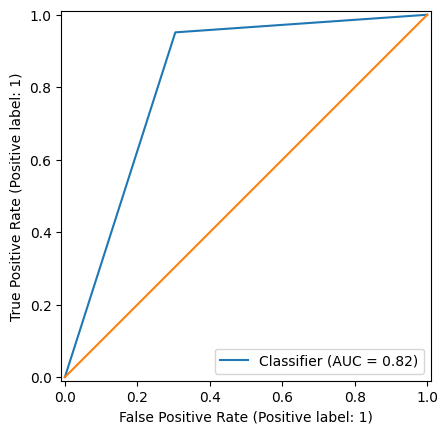

In [41]:
RocCurveDisplay.from_predictions(ytest, svm_model.predict(xtest))
plt.plot([0,1],[0,1])
plt.show()

# Random Forest

In [42]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(xtrain, ytrain)
rf_results = evaluate_model(rf_model, xtest, ytest)
rf_results

{'Accuracy': 0.8615,
 'Confusion Matrix': array([[ 702,  709],
        [ 122, 4467]], dtype=int64)}

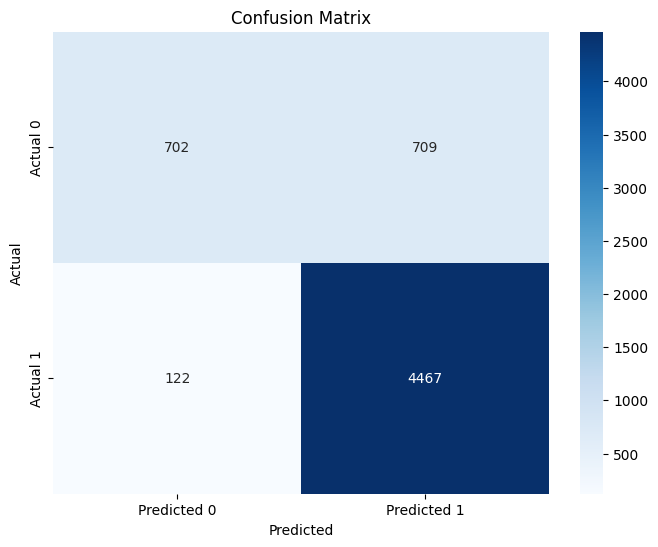

In [43]:
# Create a heatmap
cm = confusion_matrix(ytest, rf_model.predict(xtest))
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
print(classification_report(ytest, rf_model.predict(xtest)))

              precision    recall  f1-score   support

           0       0.85      0.50      0.63      1411
           1       0.86      0.97      0.91      4589

    accuracy                           0.86      6000
   macro avg       0.86      0.74      0.77      6000
weighted avg       0.86      0.86      0.85      6000



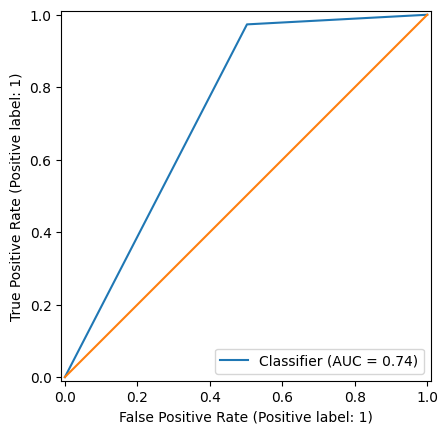

In [45]:
RocCurveDisplay.from_predictions(ytest, rf_model.predict(xtest))
plt.plot([0,1],[0,1])
plt.show()

# Visualize performance with histogram before Sampling

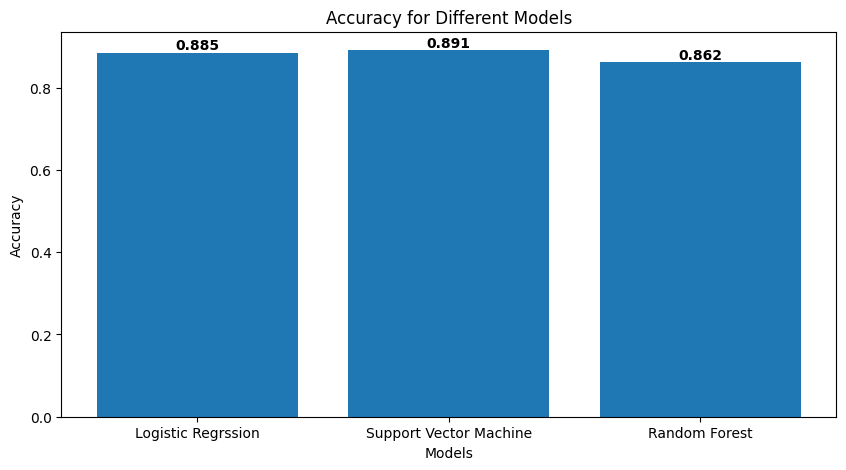

In [46]:
def plot_histogram(metric_values, model_names, metric_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = plt.bar(model_names, metric_values)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Models')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')
    plt.show()

accuracy_values = [lr_results['Accuracy'], svm_results['Accuracy'], rf_results['Accuracy']]
model_names = ['Logistic Regrssion', 'Support Vector Machine', 'Random Forest']
plot_histogram(accuracy_values, model_names, 'Accuracy')

# Since the dataset is imbalanced that's why precision, recall and f1-score is not satisfactory

# After Sampling

In [47]:
from imblearn.combine import SMOTETomek
sm = SMOTETomek(random_state=100)

In [48]:
X,Y = sm.fit_resample(x,y)

In [49]:
X.shape

(30466, 22617)

In [50]:
Y.shape

(30466,)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=.75,random_state=42)

# Logistic Regrssion

In [52]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)
lr_results = evaluate_model(lr_model, x_test, y_test)
lr_results

{'Accuracy': 0.909150584219509,
 'Confusion Matrix': array([[3545,  230],
        [ 462, 3380]], dtype=int64)}

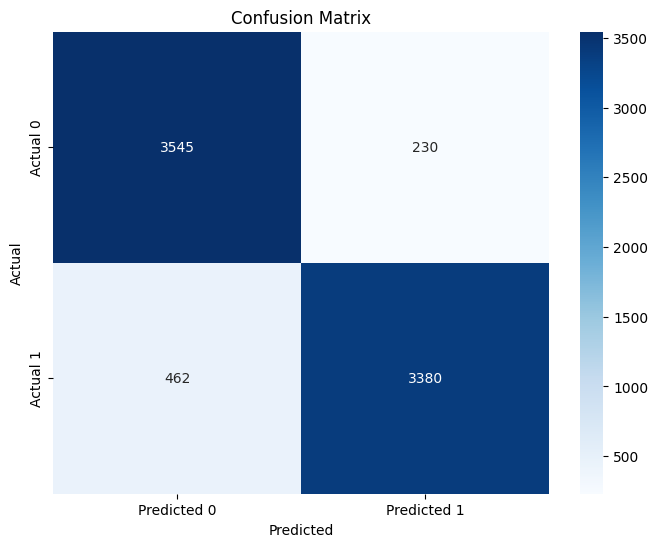

In [53]:
# Create a heatmap
cm = confusion_matrix(y_test, lr_model.predict(x_test))
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [54]:
print(classification_report(y_test, lr_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3775
           1       0.94      0.88      0.91      3842

    accuracy                           0.91      7617
   macro avg       0.91      0.91      0.91      7617
weighted avg       0.91      0.91      0.91      7617



# SVM Model

In [55]:
svm_model = SVC(kernel='linear')
svm_model.fit(x_train, y_train)
svm_results = evaluate_model(svm_model, x_test, y_test)
svm_results

{'Accuracy': 0.9224103977944073,
 'Confusion Matrix': array([[3605,  170],
        [ 421, 3421]], dtype=int64)}

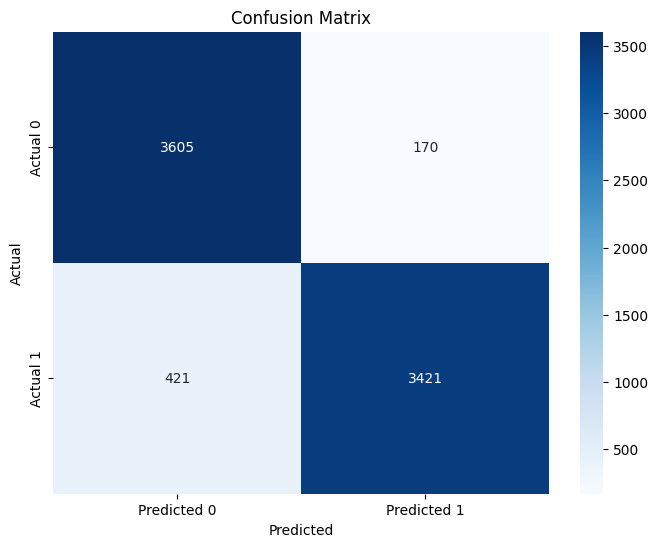

In [56]:
# Create a heatmap
cm = confusion_matrix(y_test, svm_model.predict(x_test))
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

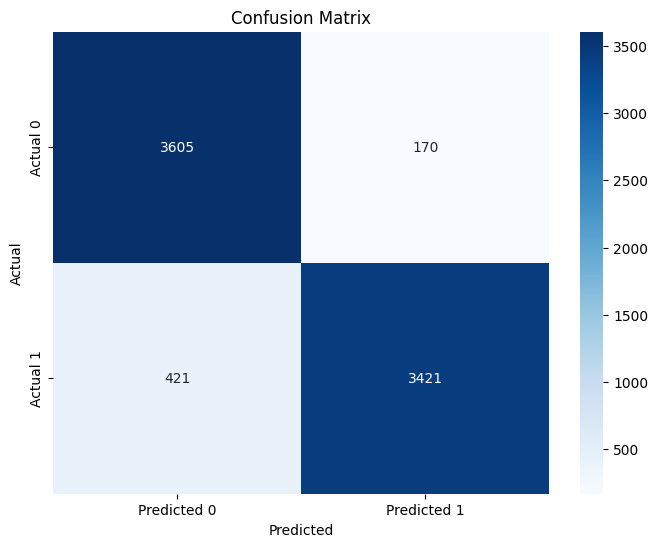

In [57]:
# Create a heatmap
cm = confusion_matrix(y_test, svm_model.predict(x_test))
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [58]:
print(classification_report(y_test, svm_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      3775
           1       0.95      0.89      0.92      3842

    accuracy                           0.92      7617
   macro avg       0.92      0.92      0.92      7617
weighted avg       0.92      0.92      0.92      7617



# Random Forest

In [59]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
rf_results = evaluate_model(rf_model, x_test, y_test)
rf_results

{'Accuracy': 0.928055664959958,
 'Confusion Matrix': array([[3523,  252],
        [ 296, 3546]], dtype=int64)}

In [60]:
print(classification_report(y_test, rf_model.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      3775
           1       0.93      0.92      0.93      3842

    accuracy                           0.93      7617
   macro avg       0.93      0.93      0.93      7617
weighted avg       0.93      0.93      0.93      7617



#  Visualize performance with histogram

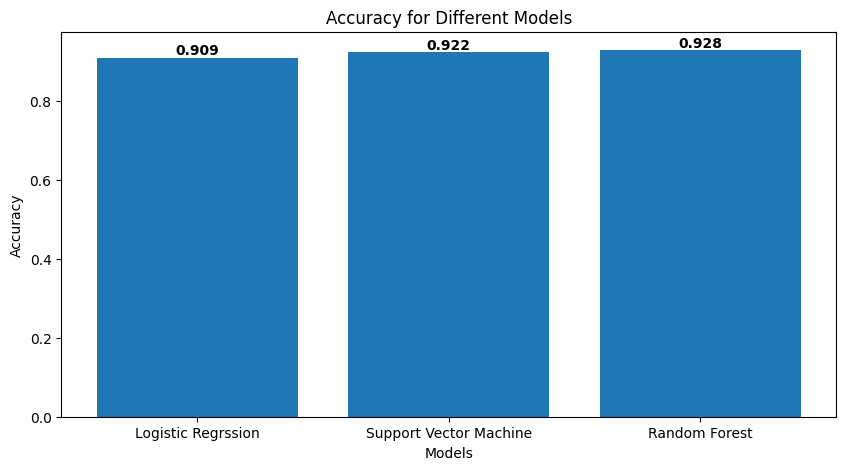

In [61]:
def plot_histogram(metric_values, model_names, metric_name):
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = plt.bar(model_names, metric_values)
    plt.xlabel('Models')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} for Different Models')

    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')
    plt.show()

accuracy_values = [lr_results['Accuracy'], svm_results['Accuracy'], rf_results['Accuracy']]
model_names = ['Logistic Regrssion', 'Support Vector Machine', 'Random Forest']
plot_histogram(accuracy_values, model_names, 'Accuracy')

# Precision, Recall, F1- Score results are satisfactory here

# Input random text and make a prediction

In [62]:
models = [lr_model, svm_model, rf_model] # objects for ml models
random_text = input() # enter any text to classify
preprocessed_text = preprocess_text(random_text) # remove punctuation and stopwords
lemmatized_text = lemmatize_text(preprocessed_text) # text scaling
text_vector = vectorizer.transform([lemmatized_text]) # tf-idf vectorizer

 'this app is fricken stupid.it froze on the kindle and it wont allow me to place most iteams just ignore the 5 * people their wrong on so many levels. the people who made this game so were you excidently press the wrong button you them your own money. jer'


In [63]:
for model in models:
    prediction = model.predict(text_vector)

    print(f"Model Name: {type(model).__name__}")
    print("Prediction:", prediction)
    print('\n')

Model Name: LogisticRegression
Prediction: [0]


Model Name: SVC
Prediction: [0]


Model Name: RandomForestClassifier
Prediction: [0]




# All the Models predict the text correctly

# Model's perforemance After Hyperparameter tuning

Using Random search since the dataset is quite large

In [65]:
from sklearn.model_selection import RandomizedSearchCV

In [66]:
#Define hyperparameters for Random Forest
rf_params = {
    'n_estimators': [101, 151, 201],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2,4,6,8,10],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf': [1, 2,3, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [68]:
rf_random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=rf_params, cv=5) 
rf_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 2, 4, 6, 8, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [101, 151, 201]})

In [69]:
y_pred_rf_gs = rf_random_search.predict(x_test) 
print("\nRandom Forest Random Search Performance:") 
print("Accuracy:", accuracy_score(y_test, y_pred_rf_gs)) 
print("Classification Report:") 
print(classification_report(y_test, y_pred_rf_gs))


Random Forest Random Search Performance:
Accuracy: 0.9003544702638834
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      3775
           1       0.89      0.91      0.90      3842

    accuracy                           0.90      7617
   macro avg       0.90      0.90      0.90      7617
weighted avg       0.90      0.90      0.90      7617

